In [ ]:
!pip install torch torchvision


In [ ]:
import torchvision.transforms as transforms  # Importing the transforms module from torchvision for image transformations
import torchvision.datasets as datasets  # Importing the datasets module from torchvision for dataset handling

# converting image into pytorch tensor and normalizing it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# loading CIFAR100 dataset
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

100%|██████████| 169001437/169001437 [00:03<00:00, 42378832.88it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Importing the DataLoader class from the torch.utils.data module
from torch.utils.data import DataLoader

In [ ]:
#the number of samples to be processed in one forward and backward pass during training or evaluation
batch_size = 64
# Creating a data loader for the training set
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Creating a data loader for the test set
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn as nn  # Importing the neural network module from PyTorch

# Defining a CNN class inheriting from nn.Module
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Calling the constructor of the parent class

        # Defining the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        # Input channels=3, output channels=32, kernel size=3x3, stride=1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # Input channels=32, output channels=64, kernel size=3x3, stride=1

        # Defining the fully connected layers
        self.fc1 = nn.Linear(64*6*6, 128)
        # Input size=64*6*6, output size=128
        self.fc2 = nn.Linear(128, 100)
        # Input size=128, output size=100 (number of classes)

    # Forward method defining the forward pass of the network
    def forward(self, x):
        # Applying the first convolutional layer followed by ReLU activation
        x = F.relu(self.conv1(x))

        # Performing max pooling with 2x2 kernel and stride 2
        x = F.max_pool2d(x, 2, 2)

        # Applying the second convolutional layer followed by ReLU activation
        x = F.relu(self.conv2(x))

        # Performing max pooling with 2x2 kernel and stride 2
        x = F.max_pool2d(x, 2, 2)

        # Reshaping the tensor to fit into the fully connected layers
        x = x.view(-1, 64*6*6)

        # Applying the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Applying the second fully connected layer (output layer)
        x = self.fc2(x)

        # Applying log softmax activation to the output (for classification)
        return F.log_softmax(x, dim=1)


In [ ]:
import torch.optim as optim
# Importing the optimization module from PyTorch

learning_rate = 0.001
 # Setting the learning rate for the optimizer
batch_size = 64
# Setting the batch size for training
epochs = 10
 # Setting the number of epochs for training

model = CNN()
# Instantiating the CNN model
criterion = nn.CrossEntropyLoss()
 # Defining the loss criterion (Cross Entropy Loss)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
 # Defining the optimizer (Adam optimizer)


In [ ]:
def train(model, train_loader, optimizer, criterion):
    # Set the model to training mode
    model.train()

    # Initialize a variable to keep track of the running loss
    running_loss = 0.0

    # Iterate over the batches of training data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Zero the gradients to avoid accumulation from previous iterations
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the loss between the predicted outputs and the actual targets
        loss = criterion(output, target)

        # Backpropagation: compute gradients of the loss with respect to model parameters
        loss.backward()

        # Update the model parameters based on the gradients computed during the backward pass
        optimizer.step()

        # Add the current batch's loss to the running loss
        running_loss += loss.item()

    # Calculate the average loss over all batches
    # and return it as the training loss for this epoch
    return running_loss / len(train_loader)


Epoch: 1/10, Loss: 3.6384
Epoch: 2/10, Loss: 2.9284
Epoch: 3/10, Loss: 2.6355
Epoch: 4/10, Loss: 2.4431
Epoch: 5/10, Loss: 2.2999
Epoch: 6/10, Loss: 2.1807
Epoch: 7/10, Loss: 2.0788
Epoch: 8/10, Loss: 1.9887
Epoch: 9/10, Loss: 1.9090
Epoch: 10/10, Loss: 1.8404


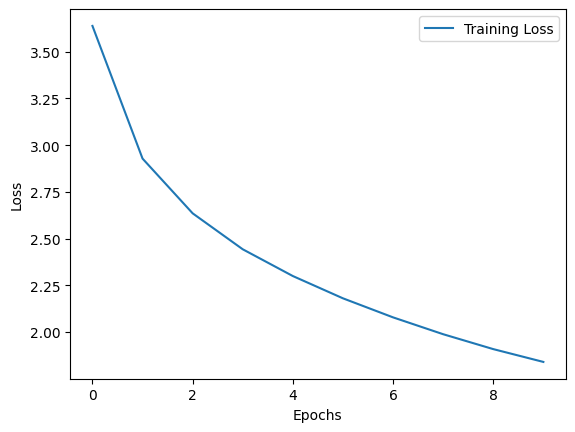

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Initialize an empty list to store training losses for each epoch
train_losses = []

# Iterate over the specified number of epochs
for epoch in range(epochs):
    # Train the model for one epoch and get the training loss
    train_loss = train(model, train_loader, optimizer, criterion)

    # Append the training loss to the list of training losses
    train_losses.append(train_loss)

    # Print epoch number and training loss
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

# Plot the training losses over epochs
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import torch

def test(model, test_loader, criterion):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to keep track of test loss and correct predictions
    test_loss = 0
    correct = 0

    # Disable gradient calculation since we are in evaluation mode
    with torch.no_grad():
        # Iterate over the test data loader
        for data, target in test_loader:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Compute the test loss using the provided criterion (e.g., CrossEntropyLoss)
            test_loss += criterion(output, target).item()

            # Get the index of the maximum value along the specified dimension (usually the class probabilities)
            pred = output.argmax(dim=1, keepdim=True)

            # Compare predictions to the true labels and sum up the correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average test loss over the dataset
    test_loss /= len(test_loader.dataset)

    # Calculate the accuracy
    accuracy = 100. * correct / len(test_loader.dataset)

    # Print test set statistics: average loss and accuracy
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy}%')

# Call the test function with the model, test data loader, and criterion
test(model, test_loader, criterion)


Test set: Average loss: 0.0386, Accuracy: 38.97%


In [ ]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16, self).__init__()
        # Define the convolutional layers of VGG16
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            # 3 input channels, 64 output channels, 3x3 kernel size, padding 1
            nn.ReLU(inplace=True),
            # ReLU activation function
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Max pooling layer with 2x2 kernel and stride 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Adaptive average pooling layer to convert any input size to a fixed output size
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        # Define the fully connected layers (classifier) of VGG16
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            # Fully connected layer with 512*7*7 input features and 4096 output features
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # Dropout layer to prevent overfitting
            nn.Linear(4096, 4096),
            # Fully connected layer with 4096 input features and 4096 output features
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # Dropout layer to prevent overfitting
            nn.Linear(4096, num_classes),
            # Final fully connected layer with num_classes output features
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.features(x)
        # Pass input through convolutional layers
        x = self.avgpool(x)
         # Apply adaptive average pooling
        x = torch.flatten(x, 1)
        # Flatten the output for the fully connected layers
        x = self.classifier(x)
        # Pass through fully connected layers
        return x

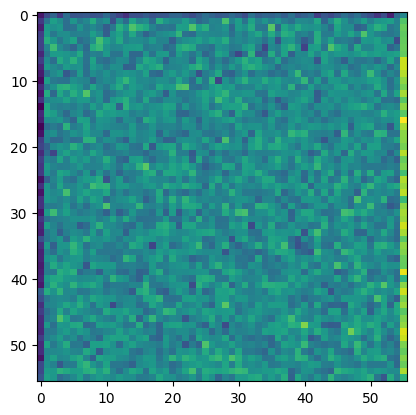

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming you have a sample image tensor
image = torch.randn(1, 3, 224, 224)
# Random image tensor with shape (batch_size, channels, height, width)

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = VGG16()
activation = {}
layer_to_visualize = 10
# Choose the layer you want to visualize

model.features[layer_to_visualize].register_forward_hook(get_activation('layer_to_visualize'))
# Pass input image through the model
output = model(image)
# Visualize the activation
plt.imshow(activation['layer_to_visualize'].squeeze()[0], cmap='viridis')
plt.show()
